<h3>KDD Cup 2009 Orange Customer Relationships</h3>

 KDD Cup is the annual Data Mining and Knowledge Discovery competition organized by ACM Special Interest Group on Knowledge Discovery and Data Mining, the leading professional organization of data miners.

 In the The KDD Cup 2009, a large marketing databases from the French Telecom company Orange had been offered to work on to predict the propensity of customers to

- switch provider (churn),
- buy new products or services (appetency),
- make the sale more profitable (up-selling)

In this dataset, there are all meaningless header names for the features. That's why we need to understand the relations between those features. The most important point for the analysis is to visualise these relations and put a theory that these relations fit in. We shall clean the data first and visualise. Later with the right questions and analysing those questions, we can find the right model for the best performance for predictions.

In [1]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Input, Embedding, Lambda, Dropout, Activation, Reshape, GlobalAveragePooling1D, merge, Flatten, Bidirectional, CuDNNGRU, add, Conv1D, GlobalMaxPooling1D,MaxPooling1D
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

Using TensorFlow backend.


In [2]:
import os
os.getcwd()

'C:\\Users\\abc\\Code_base'

In [3]:
# changing directory
os.chdir('C:/Users/abc/Documents/kdd 2019')     

In [4]:
train=pd.read_table('orange_small_train.data')

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
train.shape

(50000, 230)

In [6]:
train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [ ]:
# loading the data
'''
train = pd.read_table('orange_small_train.data')
train.head() # printing first few 5 rows

'''

In [7]:
# loading the target variable appetency
appetency = pd.read_table('orange_small_train_appetency.labels', header = None).loc[:, 0].astype('category')

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [8]:
# no of rows
appetency.shape

(50000,)

In [9]:
# loading the target variable churn and upselling
churn = pd.read_table('orange_small_train_churn.labels', header = None,sep='\t').loc[:, 0].astype('category')
upselling= pd.read_table('orange_small_train_upselling.labels', header = None,sep='\t').loc[:, 0].astype('category')

C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
C:\Users\abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


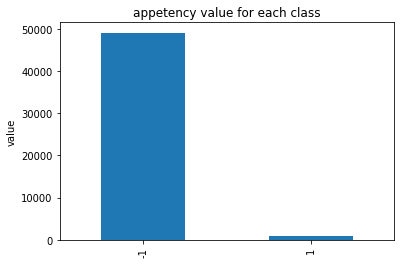

In [10]:
# plotting bar plot of target values
appetency.value_counts().plot.bar()
plt.ylabel('value')
plt.title('appetency value for each class')
plt.show()

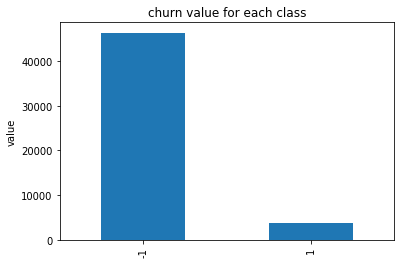

In [11]:
churn.value_counts().plot.bar()
plt.ylabel('value')
plt.title('churn value for each class')
plt.show()

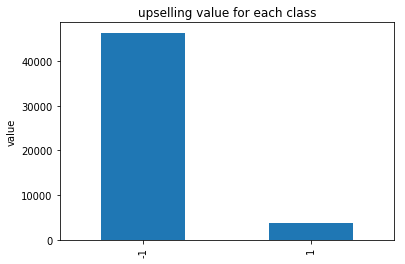

In [12]:
upselling.value_counts().plot.bar()
plt.ylabel('value')
plt.title('upselling value for each class')
plt.show()

* The above 3 plots shows that data is highly unbalanced so we should apply oversampling to balance the data while modelling.

<h3> Data Cleaning </h3>

In [13]:
for i in train.columns:
    if train[i].isnull().sum()/len(train)>=1.0:
        train.drop(i,axis=1,inplace=True)

In [14]:
train.shape

(50000, 212)

In [15]:
train['Var73']=train['Var73'].astype('float',inplace=True)

In [16]:
train['Var73'].dtypes

dtype('float64')

In [17]:
# changing the datatype of features
DataVars = train.columns
data_types = {Var: train[Var].dtype for Var in DataVars}

for Var in DataVars:
    if data_types[Var] == int:
        x = train[Var].astype(float)
        train.loc[:, Var] = x
        data_types[Var] = x.dtype
    elif data_types[Var] != float:
        
        
        
        
        x = train[Var].astype('category')
        train.loc[:, Var] = x
        data_types[Var] = x.dtype

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 212 entries, Var1 to Var229
dtypes: category(38), float64(174)
memory usage: 72.0 MB


In [20]:
# storing all the float datatype features
float_DataVars = [Var for Var in DataVars if data_types[Var] == float]

In [21]:
float_x_means = train.mean()

for Var in float_DataVars:
    x = train[Var]
    mediancol=train[Var].mean()
    isThereMissing = x.isnull()
    if isThereMissing.sum() > 0:
        train.loc[isThereMissing.tolist(), Var] = float_x_means[Var]

In [22]:
# storing all the categpry features
DataVars = train.columns

categorical_DataVars = [Var for Var in DataVars if data_types[Var] != float]


In [23]:
categorical_levels = train[categorical_DataVars].apply(lambda col: len(col.cat.categories))
categorical_x_var_names = categorical_levels[categorical_levels > 10].index

In [24]:
categorical_levels

Var191        1
Var192      361
Var193       51
Var194        3
Var195       23
Var196        4
Var197      225
Var198     4291
Var199     5073
Var200    15415
Var201        2
Var202     5713
Var203        5
Var204      100
Var205        3
Var206       21
Var207       14
Var208        2
Var210        6
Var211        2
Var212       81
Var213        1
Var214    15415
Var215        1
Var216     2016
Var217    13990
Var218        2
Var219       22
Var220     4291
Var221        7
Var222     4291
Var223        4
Var224        1
Var225        3
Var226       23
Var227        7
Var228       30
Var229        4
dtype: int64

In [25]:
def replaceInfrequentLevels(data, val=0.015):
    collapsed_categories = {}
    for categorical_x_var_name in categorical_x_var_names:
        x = data[categorical_x_var_name].copy()
        for category in x.cat.categories:
            matching_rows_yesno = x == category
            if matching_rows_yesno.sum() < val * data.shape[0]:
                if categorical_x_var_name in collapsed_categories:
                    collapsed_categories[categorical_x_var_name].append(category)
                else:
                    collapsed_categories[categorical_x_var_name] = [category]
                if 'OTHER' not in data[categorical_x_var_name].cat.categories:
                    data[categorical_x_var_name].cat.add_categories('OTHER', inplace=True)
                data.loc[matching_rows_yesno, categorical_x_var_name] = 'OTHER'
                data[categorical_x_var_name].cat.remove_categories(category, inplace=True)
    return data            

In [26]:
train= replaceInfrequentLevels(train)

In [27]:
categorical_x_nb_levels = train[categorical_x_var_names].apply(lambda col: len(col.cat.categories))
print("Number of unique values within categorical features after preprocessing:")
categorical_x_nb_levels


Number of unique values within categorical features after preprocessing:


Var192     1
Var193     4
Var195     3
Var197     8
Var198     4
Var199     4
Var200     1
Var202     1
Var204    23
Var206    12
Var207     7
Var212     7
Var214     1
Var216    13
Var217     1
Var219     5
Var220     4
Var222     4
Var226    22
Var228    11
dtype: int64

In [28]:
print(train[categorical_x_var_names].isnull().sum()/len(train))


Var192    0.00738
Var193    0.00000
Var195    0.00000
Var197    0.00286
Var198    0.00000
Var199    0.00008
Var200    0.50816
Var202    0.00002
Var204    0.00000
Var206    0.11058
Var207    0.00000
Var212    0.00000
Var214    0.50816
Var216    0.00000
Var217    0.01406
Var219    0.10422
Var220    0.00000
Var222    0.00000
Var226    0.00000
Var228    0.00000
dtype: float64


In [29]:
for categorical_var_name in categorical_x_var_names:
    train[categorical_var_name].cat.add_categories("unknown_"+categorical_var_name, inplace=True)
    train[categorical_var_name].fillna("unknown_"+categorical_var_name, inplace=True)


In [30]:
print("Percentage of missing values per Categorical feature after preprocessing:")
print(train[categorical_x_var_names].isnull().sum()/len(train))


Percentage of missing values per Categorical feature after preprocessing:
Var192    0.0
Var193    0.0
Var195    0.0
Var197    0.0
Var198    0.0
Var199    0.0
Var200    0.0
Var202    0.0
Var204    0.0
Var206    0.0
Var207    0.0
Var212    0.0
Var214    0.0
Var216    0.0
Var217    0.0
Var219    0.0
Var220    0.0
Var222    0.0
Var226    0.0
Var228    0.0
dtype: float64


In [31]:
lst=[]
for i in train.columns:
    if train[i].dtypes!=float:
        lst.append(i)
lst

['Var191',
 'Var192',
 'Var193',
 'Var194',
 'Var195',
 'Var196',
 'Var197',
 'Var198',
 'Var199',
 'Var200',
 'Var201',
 'Var202',
 'Var203',
 'Var204',
 'Var205',
 'Var206',
 'Var207',
 'Var208',
 'Var210',
 'Var211',
 'Var212',
 'Var213',
 'Var214',
 'Var215',
 'Var216',
 'Var217',
 'Var218',
 'Var219',
 'Var220',
 'Var221',
 'Var222',
 'Var223',
 'Var224',
 'Var225',
 'Var226',
 'Var227',
 'Var228',
 'Var229']

In [32]:
train_data_1 = pd.get_dummies(train, columns=['Var191',
 'Var192',
 'Var193',
 'Var194',
 'Var195',
 'Var196',
 'Var197',
 'Var198',
 'Var199',
 'Var200',
 'Var201',
 'Var202',
 'Var203',
 'Var204',
 'Var205',
 'Var206',
 'Var207',
 'Var208',
 'Var210',
 'Var211',
 'Var212',
 'Var213',
 'Var214',
 'Var215',
 'Var216',
 'Var217',
 'Var218',
 'Var219',
 'Var220',
 'Var221',
 'Var222',
 'Var223',
 'Var224',
 'Var225',
 'Var226',
 'Var227',
 'Var228',
 'Var229'])

In [33]:
train_data_1.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var228_Zy3gnGM,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_xwM2aC7IdeMC0,Var228_OTHER,Var228_unknown_Var228,Var229_am7c,Var229_mj86,Var229_oJmt,Var229_sk2h
0,11.487179,0.004029,425.298387,0.125396,238793.32885,1526.000000,7.0,48.145299,392605.656355,8.625806,...,0,0,0,0,0,0,0,0,0,0
1,11.487179,0.004029,425.298387,0.125396,238793.32885,525.000000,0.0,48.145299,392605.656355,8.625806,...,0,0,0,0,0,0,0,0,0,0
2,11.487179,0.004029,425.298387,0.125396,238793.32885,5236.000000,7.0,48.145299,392605.656355,8.625806,...,0,1,0,0,0,0,1,0,0,0
3,11.487179,0.004029,425.298387,0.125396,238793.32885,1326.437116,0.0,48.145299,392605.656355,8.625806,...,0,0,0,0,0,0,0,0,0,0
4,11.487179,0.004029,425.298387,0.125396,238793.32885,1029.000000,7.0,48.145299,392605.656355,8.625806,...,0,0,0,0,0,0,0,1,0,0


In [34]:
train_data_1.to_csv('train_cust2.csv')

In [209]:
train_data_1=pd.read_csv('train_cust2.csv')

### Taking target variable as churn

In [38]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1,churn, stratify=churn, test_size=0.2, random_state=42)

In [39]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [40]:
X_train, X_test=standardize(X_train, X_test)

In [41]:
y_train.replace(-1, 0, inplace=True)
y_test.replace(-1, 0, inplace=True)

In [42]:
X_train,X_cv, y_train, y_cv = train_test_split(X_train,y_train, stratify=y_train, test_size=0.2, random_state=42)

In [43]:
random_classifier = RandomForestClassifier()

parameters = { 'max_depth':np.arange(5,10),'n_estimators':list(range(75,301,25))}

random_grid = GridSearchCV(random_classifier, parameters, cv = 3)

random_grid.fit(X_cv, y_cv)

print("Best HyperParameter: ",random_grid.best_params_)

Best HyperParameter:  {'max_depth': 5, 'n_estimators': 75}


In [44]:
rf_model = RandomForestClassifier(
    n_estimators=75,
    #criterion='entropy',
    max_depth=5,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    #min_samples_split=100,
    #min_samples_leaf=50,
    #min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=-1,   # paralellize over all CPU cores but 2
    class_weight='balanced',    # our classes are skewed, but but too skewed
    random_state=42,
    verbose=0,
    warm_start=False)

rf_model.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [45]:
rf_pred_probs=rf_model.predict(X_train)
auc=metrics.roc_auc_score(y_train,rf_pred_probs)
auc

0.6766423881453841

In [46]:
rf_pred_probs=rf_model.predict(X_test)
auc=metrics.roc_auc_score(y_test,rf_pred_probs)
auc

0.6409505378721893

In [47]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:100].index

Index(['Var126', 'Var212_NhsEn4L', 'Var73', 'Var189', 'Var217_OTHER', 'Var74',
       'Var113', 'Var140', 'Var217_unknown_Var217', 'Var81', 'Var28', 'Var125',
       'Var13', 'Var57', 'Var210_g5HH', 'Var218_cJvF', 'Var6', 'Var210_uKAI',
       'Var153', 'Var94', 'Var205_sJzTlal', 'Var45', 'Var216_7WwuNea', 'Var38',
       'Var134', 'Var204_z5Ry', 'Var76', 'Var83', 'Var51', 'Var163',
       'Var193_RO12', 'Var24', 'Var160', 'Var119', 'Var112', 'Var149',
       'Var109', 'Var44', 'Var123', 'Var205_VpdQ', 'Var144', 'Var7', 'Var188',
       'Var35', 'Var25', 'Var65', 'Var21', 'Var195_taul', 'Var133', 'Var22',
       'Var212_XfqtO3UdzaXh_', 'Var205_09_Q', 'Var218_UYBR', 'Var228_OTHER',
       'Var107', 'Var226_szEZ', 'Var199_OTHER', 'Var206_OTHER', 'Var85',
       'Var229_am7c', 'Var204_m_h1', 'Var216_mAjbk_S', 'Var226_3Cy4', 'Var82',
       'Var219_FzaX', 'Var72', 'Var226_wX53', 'Var117', 'Var197_lK27',
       'Var226_me1d', 'Var227_ZI9m', 'Var193_OTHER', 'Var197_TyGl', 'Var84',
       'Va

> Feature Selection using Random Forest Model

In [48]:
train_data_1=train_data_1[['Var126', 'Var212_NhsEn4L', 'Var73', 'Var189', 'Var217_OTHER', 'Var74',
       'Var113', 'Var140', 'Var217_unknown_Var217', 'Var81', 'Var28', 'Var125',
       'Var13', 'Var57', 'Var210_g5HH', 'Var218_cJvF', 'Var6', 'Var210_uKAI',
       'Var153', 'Var94', 'Var205_sJzTlal', 'Var45', 'Var216_7WwuNea', 'Var38',
       'Var134', 'Var204_z5Ry', 'Var76', 'Var83', 'Var51', 'Var163',
       'Var193_RO12', 'Var24', 'Var160', 'Var119', 'Var112', 'Var149',
       'Var109', 'Var44', 'Var123', 'Var205_VpdQ', 'Var144', 'Var7', 'Var188',
       'Var35', 'Var25', 'Var65', 'Var21', 'Var195_taul', 'Var133', 'Var22',
       'Var212_XfqtO3UdzaXh_', 'Var205_09_Q', 'Var218_UYBR', 'Var228_OTHER',
       'Var107', 'Var226_szEZ', 'Var199_OTHER', 'Var206_OTHER', 'Var85',
       'Var229_am7c', 'Var204_m_h1', 'Var216_mAjbk_S', 'Var226_3Cy4', 'Var82',
       'Var219_FzaX', 'Var72', 'Var226_wX53', 'Var117', 'Var197_lK27',
       'Var226_me1d', 'Var227_ZI9m', 'Var193_OTHER', 'Var197_TyGl', 'Var84',
       'Var226_7P5s', 'Var59', 'Var68', 'Var200_unknown_Var200',
       'Var207_me75fM6ugJ', 'Var211_L84s', 'Var226_Qcbd', 'Var206_lVqb',
       'Var10', 'Var216_kq0n8Bj', 'Var195_OTHER', 'Var95',
       'Var219_unknown_Var219', 'Var152', 'Var154', 'Var223_M_8D',
       'Var225_xG3x', 'Var46', 'Var216_kq0aHkC', 'Var139', 'Var211_Mtgm',
       'Var214_unknown_Var214', 'Var223_jySVZNlOJy', 'Var36', 'Var198_iJzviRg',
       'Var158']]

In [174]:
lst1=[]
for i in train_data_1.columns:
    if train_data_1[i].dtypes==float:
        lst1.append(i)
#lst1        

In [119]:
from sklearn.preprocessing import StandardScaler
def standardize_data(X_train, X_test):
    float_feats_train = X_train[lst1]
    float_feats_test = X_test[lst1]
    scaler = StandardScaler()
    X_train_stand = pd.DataFrame(scaler.fit_transform(float_feats_train), columns = lst1, index = X_train.index)
    X_test_stand = pd.DataFrame(scaler.transform(float_feats_test), columns = lst1, index = X_test.index)
    X_train_stand = pd.merge(X_train_stand, X_train.loc[:, ~X_train.columns.isin(lst1)], left_index=True, right_index=True)
    X_test_stand = pd.merge(X_test_stand, X_test.loc[:, ~X_test.columns.isin(lst1)], left_index=True, right_index=True)
    return X_train_stand, X_test_stand

In [111]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1,churn, stratify=churn, test_size=0.2, random_state=42)

In [120]:
X_train, X_test=standardize_data(X_train, X_test)

In [121]:
y_train.replace(-1, 0, inplace=True)
y_test.replace(-1, 0, inplace=True)

### MLP model with feature selection and standarization

In [122]:
output_dim = 1
input_dim = X_train.shape[1]

batch_size = 512
nb_epoch = 50

In [123]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer='he_normal'))
model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.2))
#model.add(Dense(265, activation='relu', kernel_initializer='he_normal') )
#model.add(Dropout(0.8))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal') )
model.add(Dropout(0.8))
#model.add(Dense(64, activation='relu', kernel_initializer='he_normal') )
#model.add(Dropout(0.8))
#model.add(BatchNormalization())
model.add(Dense(output_dim, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 512)               51712     
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 257       
Total params: 183,297
Trainable params: 183,297
Non-trainable params: 0
_________________________________________________________________


In [124]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=8, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/8
32000/32000 [==============================] - 4s 138us/step - loss: 0.3516 - acc: 0.9147 - val_loss: 0.2559 - val_acc: 0.9293
Epoch 2/8
32000/32000 [==============================] - 2s 67us/step - loss: 0.2812 - acc: 0.9250 - val_loss: 0.2479 - val_acc: 0.9293
Epoch 3/8
32000/32000 [==============================] - 2s 67us/step - loss: 0.2719 - acc: 0.9257 - val_loss: 0.2450 - val_acc: 0.9293
Epoch 4/8
32000/32000 [==============================] - 2s 67us/step - loss: 0.2676 - acc: 0.9257 - val_loss: 0.2435 - val_acc: 0.9293
Epoch 5/8
32000/32000 [==============================] - 2s 67us/step - loss: 0.2612 - acc: 0.9255 - val_loss: 0.2413 - val_acc: 0.9293
Epoch 6/8
32000/32000 [==============================] - 2s 67us/step - loss: 0.2600 - acc: 0.9257 - val_loss: 0.2427 - val_acc: 0.9293
Epoch 7/8
32000/32000 [==============================] - 2s 67us/step - loss: 0.2566 - acc: 0.9259 - val_loss: 0.2408 - val_acc: 0.929

In [130]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.3287945414543152
Test accuracy: 0.9263


In [126]:
y_pred = model.predict(X_test)
print("ROC-AUC score is {}".format(metrics.roc_auc_score(y_test, y_pred)))

ROC-AUC score is 0.6877418307591965


### 1D CNN model with feature selection and standarization

In [170]:
model = Sequential()
 
model.add(Conv1D(128, 1, input_shape=(input_dim, 1), activation='relu'))
#model.add(MaxPooling1D(5))
model.add(MaxPooling1D(2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

 #model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

 #model.add(BatchNormalization())
 #model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 100, 128)          256       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 6400)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 256)               1638656   
_________________________________________________________________
dropout_64 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 257       
Total para

In [173]:
X_train_cnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [171]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=9, verbose=1, validation_split=0.2, class_weight={0.: 1.,1.: 15})
score = model.evaluate(X_test_cnn, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 58s 2ms/step - loss: 1.3815 - acc: 0.4807 - val_loss: 1.2944 - val_acc: 0.6970
Epoch 2/9
32000/32000 [==============================] - 54s 2ms/step - loss: 1.3107 - acc: 0.5284 - val_loss: 1.2587 - val_acc: 0.5628
Epoch 3/9
32000/32000 [==============================] - 54s 2ms/step - loss: 1.2927 - acc: 0.5406 - val_loss: 1.2540 - val_acc: 0.5520
Epoch 4/9
32000/32000 [==============================] - 54s 2ms/step - loss: 1.2813 - acc: 0.5580 - val_loss: 1.2551 - val_acc: 0.5044
Epoch 5/9
32000/32000 [==============================] - 53s 2ms/step - loss: 1.2796 - acc: 0.5412 - val_loss: 1.2493 - val_acc: 0.5863
Epoch 6/9
32000/32000 [==============================] - 53s 2ms/step - loss: 1.2652 - acc: 0.5517 - val_loss: 1.2433 - val_acc: 0.5464
Epoch 7/9
32000/32000 [==============================] - 55s 2ms/step - loss: 1.2620 - acc: 0.5579 - val_loss: 1.2501 - val_acc: 0.5705

In [172]:
y_pred = model.predict(X_test_cnn)
print("ROC-AUC score is {}".format( metrics.roc_auc_score(y_test, y_pred)))

ROC-AUC score is 0.6931501060688309


<h3> Taking target variable as appetency</h3>

In [176]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1, appetency, stratify=appetency, test_size=0.2, random_state=42)

In [177]:
X_train, X_test=standardize(X_train, X_test)

In [178]:
y_train.replace(-1, 0, inplace=True)
y_test.replace(-1, 0, inplace=True)

In [179]:
X_train,X_cv, y_train, y_cv = train_test_split(X_train , y_train , stratify=y_train, test_size=0.2, random_state=42)

In [180]:
y_cv.replace(-1, 0, inplace=True)

In [181]:
random_classifier = RandomForestClassifier()

parameters = { 'max_depth':np.arange(5,10),'n_estimators':list(range(75,301,25))}

random_grid = GridSearchCV(random_classifier, parameters, cv = 3)

random_grid.fit(X_cv, y_cv)

print("Best HyperParameter: ",random_grid.best_params_)

Best HyperParameter:  {'max_depth': 5, 'n_estimators': 75}


In [182]:
# Applying Random Forest classifier model

rf_model = RandomForestClassifier(
    n_estimators=75,
    #criterion='entropy',
    max_depth=5,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    #min_samples_split=100,
    #min_samples_leaf=50,
    #min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=-1,   # paralellize over all CPU cores but 2
    class_weight='balanced',    # our classes are skewed, but but too skewed
    random_state=42,
    verbose=0,
    warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [183]:
rf_pred_probs=rf_model.predict(X_cv)

auc=metrics.roc_auc_score(y_cv,rf_pred_probs)
auc

0.7398470743012414

In [184]:
rf_pred_probs=rf_model.predict(X_test)

auc=metrics.roc_auc_score(y_test,rf_pred_probs)
auc

0.7573270507162322

In [185]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:100].index

Index(['Var126', 'Var218_cJvF', 'Var218_UYBR', 'Var28', 'Var81', 'Var153',
       'Var113', 'Var163', 'Var57', 'Var94', 'Var133', 'Unnamed: 0', 'Var189',
       'Var125', 'Var13', 'Var119', 'Var73', 'Var74', 'Var140', 'Var6',
       'Var85', 'Var38', 'Var226_FSa2', 'Var226_Qcbd', 'Var72', 'Var204__xpN',
       'Var216_TDceha3', 'Var59', 'Var204_7WNq', 'Var149', 'Var225_kG3k',
       'Var34', 'Var216_11p4mKe', 'Var144', 'Var37', 'Var104', 'Var134',
       'Var105', 'Var207_7M47J5GA0pTYIFxg5uy', 'Var76', 'Var21',
       'Var216_kZJyVg2', 'Var160', 'Var188', 'Var109', 'Var199_OTHER',
       'Var204_STGZ', 'Var226_453m', 'Var226_Qu4f', 'Var25', 'Var132', 'Var83',
       'Var225_xG3x', 'Var123', 'Var194_SEuy', 'Var22', 'Var223_jySVZNlOJy',
       'Var112', 'Var226_xb3V', 'Var206_43pnToF', 'Var162', 'Var199_FoJylxy',
       'Var226_WqMG', 'Var216_mAjbk_S', 'Var216_7WwuNea', 'Var216_OTHER',
       'Var197_TyGl', 'Var51', 'Var221_oslk', 'Var173', 'Var212_NhsEn4L',
       'Var207_me75fM6ugJ', '

In [186]:
train_data_1=train_data_1[['Var126', 'Var218_cJvF', 'Var218_UYBR', 'Var28', 'Var81', 'Var153',
       'Var113', 'Var163', 'Var57', 'Var94', 'Var133', 'Unnamed: 0', 'Var189',
       'Var125', 'Var13', 'Var119', 'Var73', 'Var74', 'Var140', 'Var6',
       'Var85', 'Var38', 'Var226_FSa2', 'Var226_Qcbd', 'Var72', 'Var204__xpN',
       'Var216_TDceha3', 'Var59', 'Var204_7WNq', 'Var149', 'Var225_kG3k',
       'Var34', 'Var216_11p4mKe', 'Var144', 'Var37', 'Var104', 'Var134',
       'Var105', 'Var207_7M47J5GA0pTYIFxg5uy', 'Var76', 'Var21',
       'Var216_kZJyVg2', 'Var160', 'Var188', 'Var109', 'Var199_OTHER',
       'Var204_STGZ', 'Var226_453m', 'Var226_Qu4f', 'Var25', 'Var132', 'Var83',
       'Var225_xG3x', 'Var123', 'Var194_SEuy', 'Var22', 'Var223_jySVZNlOJy',
       'Var112', 'Var226_xb3V', 'Var206_43pnToF', 'Var162', 'Var199_FoJylxy',
       'Var226_WqMG', 'Var216_mAjbk_S', 'Var216_7WwuNea', 'Var216_OTHER',
       'Var197_TyGl', 'Var51', 'Var221_oslk', 'Var173', 'Var212_NhsEn4L',
       'Var207_me75fM6ugJ', 'Var206_sYC_', 'Var212_OTHER', 'Var205_09_Q',
       'Var211_L84s', 'Var225_ELof', 'Var205_VpdQ', 'Var204_vzJD',
       'Var229_mj86', 'Var65', 'Var68', 'Var182', 'Var222_APgdzOv',
       'Var195_LfvqpCtLOY', 'Var219_unknown_Var219', 'Var228_R4y5gQQWY8OodqDV',
       'Var171', 'Var203_HLqf', 'Var228_TCU50_Yjmm6GIBZ0lL_', 'Var69',
       'Var143', 'Var78', 'Var10', 'Var136', 'Var227_6fzt', 'Var204_DtNL',
       'Var228_F2FyR07IdsN7I', 'Var208_kIsH', 'Var204_m_h1']]

In [187]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1, appetency , stratify=appetency, test_size=0.2, random_state=42)

In [196]:
X_train, X_test=standardize(X_train, X_test)

In [188]:
y_train.replace(-1, 0, inplace=True)
y_test.replace(-1, 0, inplace=True)
y_cv.replace(-1, 0, inplace=True)

### MLP model with feature selection and standarization

In [199]:
output_dim = 1
input_dim = X_train.shape[1]

batch_size = 512
nb_epoch = 50

In [200]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer='he_normal'))
model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.2))
#model.add(Dense(265, activation='relu', kernel_initializer='he_normal') )
#model.add(Dropout(0.8))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal') )
model.add(Dropout(0.8))
#model.add(Dense(64, activation='relu', kernel_initializer='he_normal') )
#model.add(Dropout(0.8))
#model.add(BatchNormalization())
model.add(Dense(output_dim, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 512)               51712     
_________________________________________________________________
dropout_67 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 257       
Total params: 183,297
Trainable params: 183,297
Non-trainable params: 0
_________________________________________________________________


In [201]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=8, verbose=1, validation_split=0.2, class_weight={0.: 1.,1.: 50})

Train on 32000 samples, validate on 8000 samples
Epoch 1/8
32000/32000 [==============================] - 7s 206us/step - loss: 2.1006 - acc: 0.6509 - val_loss: 1.0561 - val_acc: 0.6459
Epoch 2/8
32000/32000 [==============================] - 2s 68us/step - loss: 1.3055 - acc: 0.6806 - val_loss: 1.0377 - val_acc: 0.6849
Epoch 3/8
32000/32000 [==============================] - 2s 69us/step - loss: 1.2002 - acc: 0.6932 - val_loss: 1.0297 - val_acc: 0.6950
Epoch 4/8
32000/32000 [==============================] - 2s 69us/step - loss: 1.1227 - acc: 0.7052 - val_loss: 1.0037 - val_acc: 0.7087
Epoch 5/8
32000/32000 [==============================] - 2s 75us/step - loss: 1.0853 - acc: 0.6960 - val_loss: 1.0242 - val_acc: 0.7037
Epoch 6/8
32000/32000 [==============================] - 2s 72us/step - loss: 1.0327 - acc: 0.7133 - val_loss: 0.9779 - val_acc: 0.6582
Epoch 7/8
32000/32000 [==============================] - 2s 72us/step - loss: 1.0109 - acc: 0.7129 - val_loss: 0.9773 - val_acc: 0.723

In [202]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.4688142900466919
Test accuracy: 0.7275


In [203]:
y_pred = model.predict(X_test)
print("ROC-AUC score is {}".format(metrics.roc_auc_score(y_test, y_pred)))

ROC-AUC score is 0.8170908462772176


### 1D CNN model with feature selection and standarization

In [204]:
model = Sequential()
 
model.add(Conv1D(128, 1, input_shape=(input_dim, 1), activation='relu'))
#model.add(MaxPooling1D(5))
model.add(MaxPooling1D(2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

 #model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

 #model.add(BatchNormalization())
 #model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 100, 128)          256       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 6400)              0         
_________________________________________________________________
dense_104 (Dense)            (None, 256)               1638656   
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 257       
Total para

In [205]:
X_train_cnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [206]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=9, verbose=1, validation_split=0.2, class_weight={0.: 1.,1.: 50})
score = model.evaluate(X_test_cnn, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 32000 samples, validate on 8000 samples
Epoch 1/9
32000/32000 [==============================] - 57s 2ms/step - loss: 1.3488 - acc: 0.6497 - val_loss: 1.2272 - val_acc: 0.6332
Epoch 2/9
32000/32000 [==============================] - 57s 2ms/step - loss: 1.1252 - acc: 0.6667 - val_loss: 1.1317 - val_acc: 0.7076
Epoch 3/9
32000/32000 [==============================] - 56s 2ms/step - loss: 1.0895 - acc: 0.6739 - val_loss: 1.0756 - val_acc: 0.6970
Epoch 4/9
32000/32000 [==============================] - 63s 2ms/step - loss: 1.0449 - acc: 0.6885 - val_loss: 1.0709 - val_acc: 0.6650
Epoch 5/9
32000/32000 [==============================] - 48s 2ms/step - loss: 1.0320 - acc: 0.6786 - val_loss: 1.0990 - val_acc: 0.6075
Epoch 6/9
32000/32000 [==============================] - 48s 1ms/step - loss: 1.0112 - acc: 0.6866 - val_loss: 1.0392 - val_acc: 0.6340
Epoch 7/9
32000/32000 [==============================] - 48s 2ms/step - loss: 0.9859 - acc: 0.6935 - val_loss: 1.0544 - val_acc: 0.6719

In [207]:
y_pred = model.predict(X_test_cnn)
print("ROC-AUC score is {}".format( metrics.roc_auc_score(y_test, y_pred)))

ROC-AUC score is 0.8076606288565682


### Taking target variable as Upselling

In [210]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1, upselling, stratify=upselling, test_size=0.2, random_state=42)

In [211]:
X_train, X_test=standardize(X_train, X_test)

In [212]:
y_train.replace(-1, 0, inplace=True)
y_test.replace(-1, 0, inplace=True)

In [213]:
X_train,X_cv, y_train, y_cv = train_test_split(X_train , y_train , stratify=y_train, test_size=0.2, random_state=42)

In [214]:
y_cv.replace(-1, 0, inplace=True)

In [215]:
random_classifier = RandomForestClassifier()

parameters = { 'max_depth':np.arange(5,10),'n_estimators':list(range(75,301,25))}

random_grid = GridSearchCV(random_classifier, parameters, cv = 3)

random_grid.fit(X_cv, y_cv)

print("Best HyperParameter: ",random_grid.best_params_)

Best HyperParameter:  {'max_depth': 5, 'n_estimators': 75}


In [216]:
rf_model = RandomForestClassifier(
    n_estimators=75,
    #criterion='entropy',
    max_depth=5,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    #min_samples_split=100,
    #min_samples_leaf=50,
    #min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
    n_jobs=-1,   # paralellize over all CPU cores but 2
    class_weight='balanced',    # our classes are skewed, but but too skewed
    random_state=42,
    verbose=0,
    warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [217]:
rf_pred_probs=rf_model.predict(X_cv)

auc=metrics.roc_auc_score(y_cv,rf_pred_probs)
auc

0.7572707160626417

In [218]:
rf_pred_probs=rf_model.predict(X_test)

auc=metrics.roc_auc_score(y_test,rf_pred_probs)
auc

0.7475911898325449

In [219]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:100].index

Index(['Var126', 'Var28', 'Var153', 'Var225_ELof', 'Var6', 'Var226_FSa2',
       'Var113', 'Var38', 'Var218_UYBR', 'Var133', 'Var13', 'Var163', 'Var134',
       'Var81', 'Unnamed: 0', 'Var211_L84s', 'Var183', 'Var119', 'Var94',
       'Var26', 'Var76', 'Var57', 'Var73', 'Var125', 'Var61', 'Var135',
       'Var140', 'Var219_FzaX', 'Var149', 'Var74', 'Var16', 'Var102',
       'Var210_uKAI', 'Var97', 'Var85', 'Var218_cJvF', 'Var44', 'Var7',
       'Var43', 'Var24', 'Var173', 'Var25', 'Var225_kG3k', 'Var204_RVjC',
       'Var51', 'Var196_z3mO', 'Var197_OTHER', 'Var228_R4y5gQQWY8OodqDV',
       'Var216_NGZxnJM', 'Var109', 'Var189', 'Var204_DtNL', 'Var78', 'Var107',
       'Var216_kq0n8Bj', 'Var22', 'Var112', 'Var10', 'Var216_beK4AFX',
       'Var166', 'Var206_zm5i', 'Var144', 'Var165', 'Var123', 'Var193_2Knk1KF',
       'Var132', 'Var83', 'Var211_Mtgm', 'Var197_TyGl', 'Var226_xb3V',
       'Var229_mj86', 'Var226_7P5s', 'Var157', 'Var216_mAja5EA', 'Var5',
       'Var219_OFWH', 'Var72', 'Var1

In [220]:
train_data_1=train_data_1[['Var126', 'Var28', 'Var153', 'Var225_ELof', 'Var6', 'Var226_FSa2',
       'Var113', 'Var38', 'Var218_UYBR', 'Var133', 'Var13', 'Var163', 'Var134',
       'Var81', 'Unnamed: 0', 'Var211_L84s', 'Var183', 'Var119', 'Var94',
       'Var26', 'Var76', 'Var57', 'Var73', 'Var125', 'Var61', 'Var135',
       'Var140', 'Var219_FzaX', 'Var149', 'Var74', 'Var16', 'Var102',
       'Var210_uKAI', 'Var97', 'Var85', 'Var218_cJvF', 'Var44', 'Var7',
       'Var43', 'Var24', 'Var173', 'Var25', 'Var225_kG3k', 'Var204_RVjC',
       'Var51', 'Var196_z3mO', 'Var197_OTHER', 'Var228_R4y5gQQWY8OodqDV',
       'Var216_NGZxnJM', 'Var109', 'Var189', 'Var204_DtNL', 'Var78', 'Var107',
       'Var216_kq0n8Bj', 'Var22', 'Var112', 'Var10', 'Var216_beK4AFX',
       'Var166', 'Var206_zm5i', 'Var144', 'Var165', 'Var123', 'Var193_2Knk1KF',
       'Var132', 'Var83', 'Var211_Mtgm', 'Var197_TyGl', 'Var226_xb3V',
       'Var229_mj86', 'Var226_7P5s', 'Var157', 'Var216_mAja5EA', 'Var5',
       'Var219_OFWH', 'Var72', 'Var160', 'Var204_m_h1', 'Var223_LM8l689qOp',
       'Var226_5Acm', 'Var216_kZJtVhC', 'Var172', 'Var35', 'Var196_1K8T',
       'Var96', 'Var216_OTHER', 'Var206_IYzP', 'Var194_SEuy', 'Var193_RO12',
       'Var188', 'Var216_7WwuNea', 'Var65', 'Var33', 'Var227_vJ_w8kB',
       'Var226_uWr3', 'Var216_kZJyVg2', 'Var206_unknown_Var206', 'Var197_lK27',
       'Var221_zCkv']]

In [221]:
X_train,X_test, y_train, y_test = train_test_split(train_data_1, upselling , stratify=upselling, test_size=0.2, random_state=42)

In [222]:
X_train, X_test=standardize(X_train, X_test)

In [223]:
y_train.replace(-1, 0, inplace=True)
y_test.replace(-1, 0, inplace=True)

### MLP model with feature selection and standarization

In [224]:
output_dim = 1
input_dim = X_train.shape[1]

batch_size = 512
nb_epoch = 50

In [226]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer='he_normal'))
model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.2))
#model.add(Dense(265, activation='relu', kernel_initializer='he_normal') )
#model.add(Dropout(0.8))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal') )
model.add(Dropout(0.8))
#model.add(Dense(64, activation='relu', kernel_initializer='he_normal') )
#model.add(Dropout(0.8))
#model.add(BatchNormalization())
model.add(Dense(output_dim, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 512)               51712     
_________________________________________________________________
dropout_71 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_72 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 257       
Total params: 183,297
Trainable params: 183,297
Non-trainable params: 0
_________________________________________________________________


In [227]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=8, verbose=1, validation_split=0.2, class_weight={0.: 1.,1.: 13})

Train on 32000 samples, validate on 8000 samples
Epoch 1/8
32000/32000 [==============================] - 7s 214us/step - loss: 1.5517 - acc: 0.6031 - val_loss: 1.0766 - val_acc: 0.6029
Epoch 2/8
32000/32000 [==============================] - 2s 76us/step - loss: 1.1475 - acc: 0.6319 - val_loss: 1.0378 - val_acc: 0.6614
Epoch 3/8
32000/32000 [==============================] - 3s 83us/step - loss: 1.0693 - acc: 0.6613 - val_loss: 1.0030 - val_acc: 0.6367
Epoch 4/8
32000/32000 [==============================] - 3s 83us/step - loss: 1.0383 - acc: 0.6718 - val_loss: 0.9844 - val_acc: 0.6640
Epoch 5/8
32000/32000 [==============================] - 3s 79us/step - loss: 1.0005 - acc: 0.6882 - val_loss: 0.9702 - val_acc: 0.7146
Epoch 6/8
32000/32000 [==============================] - 3s 89us/step - loss: 0.9812 - acc: 0.7034 - val_loss: 0.9623 - val_acc: 0.7001
Epoch 7/8
32000/32000 [==============================] - 4s 125us/step - loss: 0.9574 - acc: 0.7231 - val_loss: 0.9588 - val_acc: 0.71

In [228]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.5093770072937012
Test accuracy: 0.725


In [229]:
y_pred = model.predict(X_test)
print("ROC-AUC score is {}".format(metrics.roc_auc_score(y_test, y_pred)))

ROC-AUC score is 0.8088366256476685


### 1D CNN model with feature selection and standarization

In [230]:
model = Sequential()
 
model.add(Conv1D(128, 1, input_shape=(input_dim, 1), activation='relu'))
#model.add(MaxPooling1D(5))
model.add(MaxPooling1D(2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

 #model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

 #model.add(BatchNormalization())
 #model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 100, 128)          256       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 6400)              0         
_________________________________________________________________
dense_109 (Dense)            (None, 256)               1638656   
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 257       
Total para

In [231]:
X_train_cnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

In [232]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_cnn, y_train, batch_size=batch_size, epochs=19, verbose=1, validation_split=0.2, class_weight={0.: 1.,1.: 1})
score = model.evaluate(X_test_cnn, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 32000 samples, validate on 8000 samples
Epoch 1/19
32000/32000 [==============================] - 57s 2ms/step - loss: 0.2685 - acc: 0.9157 - val_loss: 0.2270 - val_acc: 0.9279
Epoch 2/19
32000/32000 [==============================] - 54s 2ms/step - loss: 0.2290 - acc: 0.9260 - val_loss: 0.2223 - val_acc: 0.9279
Epoch 3/19
32000/32000 [==============================] - 52s 2ms/step - loss: 0.2249 - acc: 0.9260 - val_loss: 0.2198 - val_acc: 0.9279
Epoch 4/19
32000/32000 [==============================] - 53s 2ms/step - loss: 0.2251 - acc: 0.9260 - val_loss: 0.2190 - val_acc: 0.9279
Epoch 5/19
32000/32000 [==============================] - 58s 2ms/step - loss: 0.2240 - acc: 0.9260 - val_loss: 0.2215 - val_acc: 0.9279
Epoch 6/19
32000/32000 [==============================] - 54s 2ms/step - loss: 0.2235 - acc: 0.9260 - val_loss: 0.2211 - val_acc: 0.9279
Epoch 7/19
32000/32000 [==============================] - 59s 2ms/step - loss: 0.2210 - acc: 0.9260 - val_loss: 0.2171 - val_acc:

In [233]:
y_pred = model.predict(X_test_cnn)
print("ROC-AUC score is {}".format( metrics.roc_auc_score(y_test, y_pred)))

ROC-AUC score is 0.8018233713251859


In [234]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "Target Variable", "Test AUC"]
x.add_row(['MLP model','churn','0.687'])
x.add_row(['1D CNN model','churn','0.693'])
x.add_row(['MLP model','appetency','0.817'])
x.add_row(['1D CNN model','appetency','0.807'])
x.add_row(['MLP model','upselling','0.808'])
x.add_row(['1D CNN model','upselling','0.801'])
print(x)

+--------------+-----------------+----------+
|  Model Name  | Target Variable | Test AUC |
+--------------+-----------------+----------+
|  MLP model   |      churn      |  0.687   |
| 1D CNN model |      churn      |  0.693   |
|  MLP model   |    appetency    |  0.817   |
| 1D CNN model |    appetency    |  0.807   |
|  MLP model   |    upselling    |  0.808   |
| 1D CNN model |    upselling    |  0.801   |
+--------------+-----------------+----------+


### Steps to be followed

1. Acquiring the dataset.
2. Clean the dataset and get it into a format convenient for analysis.
3. Summarizing and visualizing important characteristics and statistical properties of the dataset.
4. Building models to predict the customer relationship behaviour, evaluate the results of models, and eventually, choose the best suitable predictive model .

### Refereces

* https://www.kaggle.com/asminalev/kddcup-2009-data-analysis
* https://github.com/jjmanrique/KDD-Cup-2009/blob/master/KDD_small.ipynb
    